In [13]:
rdata_read = load("../../../data/wage2015_subsample_inference.RData")
data = rdata_read["data"]
names(data)
println("Number of Rows : ", size(data)[1],"\n","Number of Columns : ", size(data)[2],) #rows and columns

Number of Rows : 5150
Number of Columns : 20


# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

In [ ]:
Pkg.add("DataFrames")
Pkg.add("Dates")
Pkg.add("Plots")
Pkg.add("CategoricalArrays")

In [4]:
using Pkg
using DataFrames
using Dates
using Plots
using Statistics,RData  #upload data of R format 
using CategoricalArrays # categorical data 

***Variable description***

- occ : occupational classification
- ind : industry classification
- lwage : log hourly wage
- sex : gender (1 female) (0 male)
- shs : some high school
- hsg : High school graduated
- scl : Some College
- clg: College Graduate
- ad: Advanced Degree
- ne: Northeast
- mw: Midwest
- so: South
- we: West
- exp1: experience

### **1.  Analysis in the subset of workers with advanced college education (variables scl, clg, ad).**

Next, we will conduct an analysis for the subset of workers with advanced college education. To do this, we will restrict our data and keep only those who have Some College, College Graduate, or Advanced Degree. 

In [19]:
sub_data = data[(data[!, :scl] .== 1) .| (data[!, :clg] .== 1) .| (data[!, :ad] .== 1), :]
Z = data[(data[!, :scl] .== 1) .| (data[!, :clg] .== 1) .| (data[!, :ad] .== 1), 
         [:lwage, :sex, :shs, :hsg, :scl, :clg, :ad, :ne, :mw, :so, :we, :exp1]]
data_female = data[(data[!, :sex] .== 1) .& ((data[!, :scl] .== 1) .| (data[!, :clg] .== 1) .| (data[!, :ad] .== 1)), :]
Z_female = data_female[!, [:lwage, :sex, :shs, :hsg, :scl, :clg, :ad, :ne, :mw, :so, :we, :exp1]]

# Filtrar datos para hombres
data_male = data[(data[!, :sex] .== 0) .& ((data[!, :scl] .== 1) .| (data[!, :clg] .== 1) .| (data[!, :ad] .== 1)), :]
Z_male = data_male[!, [:lwage, :sex, :shs, :hsg, :scl, :clg, :ad, :ne, :mw, :so, :we, :exp1]]

means = DataFrame( variables = names(Z), All = describe(Z, :mean)[!,2], Men = describe(Z_male,:mean)[!,2], Female = describe(Z_female,:mean)[!,2])


Row,variables,All,Men,Female
,String,Float64,Float64,Float64
1,lwage,3.06275,3.09945,3.02442
2,sex,0.489136,0.0,1.0
3,shs,0.0,0.0,0.0
4,hsg,0.0,0.0,0.0
5,scl,0.379438,0.405602,0.352113
6,clg,0.433492,0.436203,0.430661
7,ad,0.187069,0.158195,0.217226
8,ne,0.2292,0.219917,0.238895
9,mw,0.249868,0.245851,0.254063


In particular, the table above shows that the difference in average logwage between men and women is equal to  $0.0750$

In [20]:
mean(Z_female[:,:lwage]) - mean(Z_male[:,:lwage])

-0.07503200512595809

Thus, the unconditional gender wage gap is about $7,5$\% for the group of never married workers (women get paid less on average in our sample). 

#### 1.1 OLS estimation without controls

In [31]:
#install all the package that we can need
#Pkg.add("GLM") # package to run models 
#Pkg.add("StatsPlots")
#Pkg.add("MLBase")
#Pkg.add("Tables")
#Pkg.add("CovarianceMatrices") # robust standar error 
# Load the installed packages
using DataFrames
using Tables
using GLM
using CovarianceMatrices


In [42]:
nocontrol_model = lm(@formula(lwage ~ sex), sub_data)
nocontrol_est = GLM.coef(nocontrol_model)[2]
nocontrol_se = GLM.coeftable(nocontrol_model).cols[2][2]

# nocontrol_se1 = stderror(HC1(), nocontrol_model)[2]
CI1upper = confint(nocontrol_model)[2, 2]
CI1low = confint(nocontrol_model)[2, 1]

println("The estimated gender coefficient is ", nocontrol_est ," and the corresponding robust standard error is " ,nocontrol_se)

The estimated gender coefficient is -0.07503200512595283 and the corresponding robust standard error is 0.018373837141543423


#### 1.2 OLS estimation with controls

Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

In [136]:
flex = @formula(lwage ~ sex + (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))
control_model = lm(flex , sub_data)
control_est = GLM.coef(control_model)[2]
control_se = GLM.coeftable(control_model).cols[2][2]
#control_se1 = stderror( HC0(), control_model)[2]
CI2upper = confint(control_model)[2, 2]
CI2low = confint(control_model)[2, 1]

println("Coefficient for OLS with controls " , control_est, "robust standard error:", control_se)

Coefficient for OLS with controls -0.06763389814641799robust standard error:0.017476482805130963


#### 1.3 Partialling-Out using ols

In [138]:
# models
# model for Y
flex_y = @formula(lwage ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))
flex_d = @formula(sex ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))

t_Y = residuals(lm(flex_y, sub_data))
t_D = residuals(lm(flex_d, sub_data))

data_res = DataFrame(t_Y = t_Y, t_D = t_D )
partial_fit = lm(@formula(t_Y ~ t_D), data_res)
partial_est = GLM.coef(partial_fit)[2]

# standard error
partial_se = GLM.coeftable(partial_fit).cols[2][2]

#partial_se1 = stderror( HC0(), partial_fit)[2]

#condifence interval
CI3upper = confint(partial_fit)[2, 2]
CI3low = confint(partial_fit)[2, 1]
println("Coefficient for D via partiallig-out ", partial_est, " robust standard error:", partial_se )

Coefficient for D via partiallig-out -0.06763389814419263 robust standard error:0.01692811003370123


We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

In the following, we illustrate the partialling-out approach using lasso instead of ols. 

In [55]:
DataFrame(modelos = [ "Without controls", "full reg", "partial reg" ], 
Estimate = [nocontrol_est,control_est, partial_est], 
StdError = [nocontrol_se,control_se, partial_se])

Row,modelos,Estimate,StdError
,String,Float64,Float64
1,Without controls,-0.075032,0.0183738
2,full reg,-0.0676339,0.0174765
3,partial reg,-0.0676339,0.0169281


### **2.   Descriptive statistics subset of workers with advanced college education (variables scl, clg, ad).**


##### 2.1)  Wage & Lwage

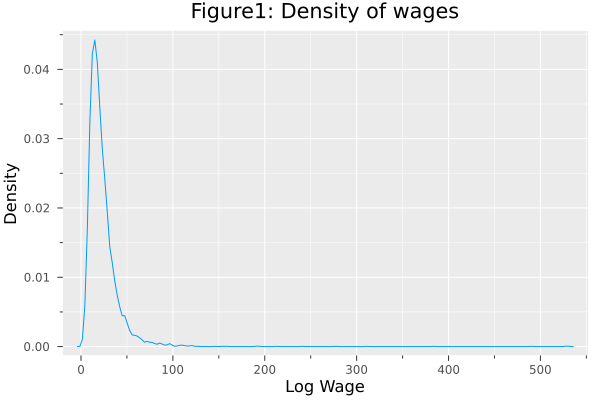

In [130]:
plot_density = density(data.wage, fillcolor = :blue, fillalpha = 0.5, 
                        legend = false, title = "Figure1: Density of wages",
                        xlabel = "Log Wage", ylabel = "Density")

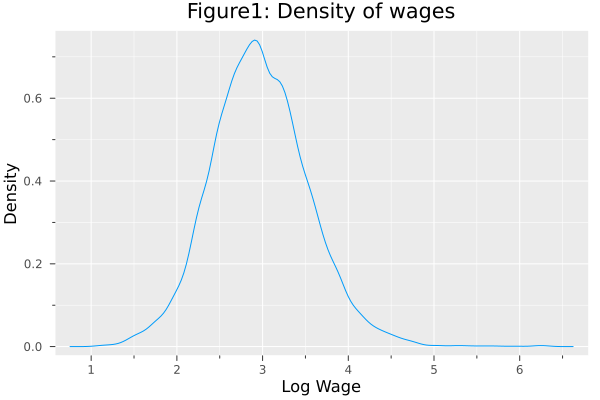

In [131]:
plot_density = density(data.lwage, fillcolor = :blue, fillalpha = 0.5, 
                        legend = false, title = "Figure1: Density of wages",
                        xlabel = "Log Wage", ylabel = "Density")

#### 2.2 Descriptive data by gender

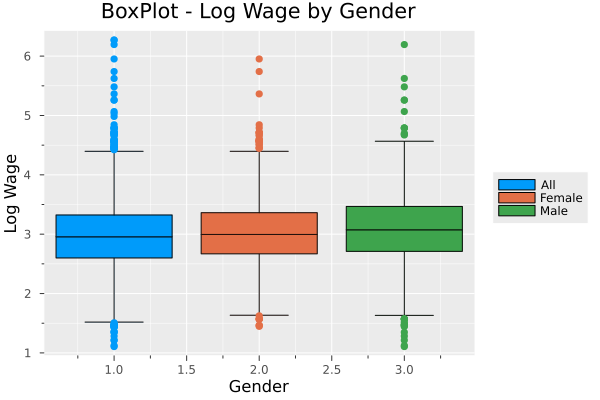

In [200]:
Bplot = boxplot(data.lwage, title = "BoxPlot - Log Wage by Gender",
    ylabel = "Log Wage", xlabel = "Gender",label = "All", legend =:outerright )
boxplot!(Z_female.lwage, label = "Female" )
boxplot!(Z_male.lwage, label = "Male")

### **3. Confidence Interval of sex's coefficient for a different models:**


In [139]:
CIdf = DataFrame(
    x = ["No Control", "With Control", "Partialling Out"],
    y = [nocontrol_est, control_est, partial_est],
    lower = [CI1low, CI2low, CI3low],
    upper = [CI1upper, CI2upper, CI3upper]
)

Row,x,y,lower,upper
,String,Float64,Float64,Float64
1,No Control,-0.075032,-0.100823,-0.0344448
2,With Control,-0.0676339,-0.101899,-0.0333689
3,Partialling Out,-0.0676339,-0.100823,-0.0344448


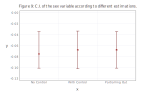

In [163]:
using Gadfly
plot_density =  Gadfly.plot(CIdf, x=:x, y=:y, ymin=:lower, ymax=:upper,
                    Geom.point(), Geom.errorbar(),
                    Guide.title("Figure 9: C.I. of the sex variable according to different estimations."),
                    Theme(panel_fill="white", panel_stroke=colorant"black", default_color=colorant"darkred"))
display(plot_density)


### **4. Replication of the figure: Experience Profiles and Wage Gap for High School Graduates**


In [193]:
data_hsg = data[data.hsg .== 1, :]
data_clg = data[data.clg .== 1, :]
data_scl = data[data.scl .== 1, :]

data_clgm = data_clg[data_clg.sex .== 0, :]  # Hombres
data_clgf = data_clg[data_clg.sex .== 1, :]  # Mujeres

Row,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,gender
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…,String
1,9.61538,2.26336,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18,Female
2,28.8462,3.36198,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22,Female
3,11.7308,2.46222,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.01,0.001,0.0001,1650,5,7460,14,Female
4,19.2308,2.95651,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.16,0.064,0.0256,3255,10,8190,18,Female
5,16.3462,2.79399,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,110,1,7870,17,Female
6,24.0385,3.17966,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,2630,9,4870,9,Female
7,41.2088,3.71865,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,11.0,1.21,1.331,1.4641,4700,16,5790,9,Female
8,11.7788,2.46631,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,5860,17,6870,12,Female
9,13.0769,2.57085,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,1.0,1.0,725,2,8590,19,Female


In [194]:
# Tabla_hsg
Tabla_hsg = data_hsg.groupby('exp1').agg(Promlwageo=('lwage', 'mean')).reset_index()
nivel_hsg = sorted(data_hsg['exp1'].unique())

Promedio = []
for nivel in nivel_hsg:
    Promedio.append(data_hsg[data_hsg['exp2'] <= nivel]['lwage'].mean())

Tabla_hsg['PromMov'] = Promedio
print(Tabla_hsg.head())

# Tabla_clg
Tabla_clg = data_clg.groupby('exp2').agg(Promlwageo=('lwage', 'mean')).reset_index()
Tabla_clgm = data_clg.groupby('exp2').agg(Promlwageo=('lwage', 'mean')).reset_index()
Tabla_clgf = data_clg.groupby('exp2').agg(Promlwageo=('lwage', 'mean')).reset_index()

nivel_clg = sorted(data_clg['exp2'].unique())
nivel_clgm = sorted(data_clgm['exp2'].unique())
nivel_clgf = sorted(data_clgf['exp2'].unique())

Promedio = []
for nivel in nivel_clg:
    Promedio.append(data_clg[data_clg['exp2'] <= nivel]['lwage'].mean())

Tabla_clg['PromMov'] = Promedio
Tabla_clgm['PromMov'] = Promedio
Tabla_clgf['PromMov'] = Promedio
print(Tabla_clg.head())


LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://C:/Users/vn.hoyosm/Documents/GitHub/CausalAI-Course/labs/julia_notebooks/lab1/In[194]#2:31\[90mIn[194]:2:31[0;0m]8;;\
# Tabla_hsg
Tabla_hsg = data_hsg.groupby('[48;2;120;70;70mexp1[0;0m').agg(Promlwageo=('lwage', 'mean')).reset_index()
[90m#                             └──┘ ── [0;0m[91mcharacter literal contains multiple characters[0;0m

In [198]:
# Definir la fórmula del modelo
formula = @formula(lwage ~ sex + (exp1 + exp2 + exp3 + exp4) * (shs + hsg + scl + clg + occ2 + ind2 + mw + so + we))

# Ajustar el modelo
control_fit1 = lm(formula, data)

# Hacer predicciones
predict = predict(control_fit1)

# Añadir las predicciones al DataFrame original
data[!, :Predict] = predict

# Filtrar datos para scl y clg
data_sclP = filter(row -> row.scl == 1, data)
data_clgP = filter(row -> row.clg == 1, data)
data_hsgP = filter(row -> row.hsg == 1, data)

data_clgPm = filter(row -> row.clg == 1 && row.sex == 0, data)  # Hombres
data_clgPf = filter(row -> row.clg == 1 && row.sex == 1, data)  # Mujeres


LoadError: cannot assign a value to imported variable GLM.predict from module Main

In [191]:
using Statistics

# Using "sclP"
Tabla_hsgP = by(data_hsgP, :exp2, Predict = :Predict => mean)
Tabla_hsgP = sort!(Tabla_hsgP, :exp2)

nivel_hsgP = sort(unique(data_hsgP.exp2))

Promedio = [mean(data_hsgP[data_hsgP.exp2 .<= nivel, :Predict]) for nivel in nivel_hsgP]
Tabla_hsgP[!, :PromMovP] = Promedio

println(first(Tabla_hsgP, 5))

# Repeat for "clgP"
Tabla_clgP = by(data_clgP, :exp2, Predict = :Predict => mean)
Tabla_clgP = sort!(Tabla_clgP, :exp2)

Tabla_clgPf = by(data_clgPf, :exp2, Predict = :Predict => mean)
Tabla_clgPf = sort!(Tabla_clgPf, :exp2)

Tabla_clgPm = by(data_clgPm, :exp2, Predict = :Predict => mean)
Tabla_clgPm = sort!(Tabla_clgPm, :exp2)

nivel_clgP = sort(unique(data_clgP.exp2))

Promedio = [mean(data_clgP[data_clgP.exp2 .<= nivel, :Predict]) for nivel in nivel_clgP]
Tabla_clgP[!, :PromMov] = Promedio
Tabla_clgPf[!, :PromMov] = Promedio

Promediof = Promedio[1:end-1]
Tabla_clgPm[!, :PromMov] = Promediof

println(first(Tabla_clgP, 5))

LoadError: UndefVarError: `data_hsgP` not defined

In [ ]:
using Plots

# Datos
x = Tabla_clg[:exp2]
x_3 = Tabla_clgPm[:exp2]
y = Tabla_clg[:PromMov]
y_3 = Tabla_clgPm[:PromMov]

# Crear el gráfico
plot(x, y, color=:navy, linestyle=:solid, label="Actual CLG")
plot!(x_3, y_3, color=:darkred, linestyle=:dash)

# Ajustes del gráfico
ylims!(3, 3.2)
xlims!(0, 15)
xlabel!("Years of Potential Experience")
ylabel!("Log Wage (or Wage Gap)")
title!("Comparison between actual and fitted for CLG and HSG Male")
grid!(linestyle=:dash, color=:gray)

# Marcas de los ejes
xticks!(0:5:15)

# Leyenda
legend!(:topright, fontsize=8)

# Mostrar el gráfico
display(plot!())

# Datos
x = Tabla_clg[:exp2]
x_3 = Tabla_clgPf[:exp2]
y = Tabla_clg[:PromMov]
y_3 = Tabla_clgPf[:PromMov]

# Crear el gráfico
plot(x, y, color=:navy, linestyle=:solid, label="Actual CLG")
plot!(x_3, y_3, color=:darkred, linestyle=:dash)

# Ajustes del gráfico
ylims!(3, 3.2)
xlims!(0, 15)
xlabel!("Years of Potential Experience")
ylabel!("Log Wage (or Wage Gap)")
title!("Comparison between actual and fitted for CLG and HSG Female")
grid!(linestyle=:dash, color=:gray)

# Marcas de los ejes
xticks!(0:5:15)

# Leyenda
legend!(:topright, fontsize=8)

# Mostrar el gráfico
display(plot!())